<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">2018-2 · Máster universitario en Ciencia de datos (Data Science)</p>
<p style="margin: 0; text-align:right;">TFM · Sistema Reactivo Sobre Dispositivos IoT</p>
</div>
</div>
<div style="width:0%;">&nbsp;</div>


# TFM: Sistema Reactivo Sobre Dispositivos IoT - Parte II

Este notebook contiene la parte de generación del modelo del trabajo realizado para el TFM.

In [1]:
# carga de librerías necesarias:
%matplotlib inline
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import ceil
import warnings
warnings.filterwarnings('ignore')

#imports para generar el modelo
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [2]:
#Se carga el fichero con el conjunto de datos:
dataset = pd.read_excel("./datos/dataset_fecha_hora_clean.xlsx",
                        header=[0],
                        columns = ['HORA','HORA_MIN','HORA_NORM','TIPO_USER','TIPO_USER_INT','ID_ACCION','TIPO_DIA','TIPO_DIA_INT']
                       )       

In [3]:
#añadimos esta celda por si quisiesemos modificar el intervalo de tiempo
#INTERVALO = 10
#dataset['HORA_NORM'] = [ceil(hora_min/INTERVALO) for hora_min in dataset['HORA_MIN']]

In [4]:
#Se seleccionan las columnas con las que se va a trabajar:
dataset = dataset[['HORA_NORM','TIPO_USER_INT','ID_ACCION','TIPO_DIA_INT']]

In [5]:
#almacenamos las columnas de datos y predicción en dos arrays
X = np.array(dataset[['TIPO_USER_INT','ID_ACCION','TIPO_DIA_INT']])
y = np.array(dataset[['HORA_NORM']])

print(X.shape)
print(y.shape)

(30479, 3)
(30479, 1)


In [6]:
#dividimos los datos en conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1028)

In [7]:
# árboles de decisión
# definimos el clasificador DecisionTreeClassifier, probaremos diferentes valores para el parámetro max_depth
clf = DecisionTreeClassifier(class_weight='balanced')

param_range = [1,5,10,12,15,18,20,25,30,50]

#obtenemos las puntuaciones de entrenamiento y test, utilizamos validación cruzada (cv=3)
train_scores, test_scores = validation_curve(clf, X_train, y_train,
                                             param_name="max_depth",
                                             param_range=param_range,
                                             cv=3, scoring="accuracy", n_jobs=1)

# calculamos la media y desviación típica de las puntuaciones del conjunto de entrenamiento
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# calculamos la media y desviación típica de las puntuaciones del conjunto de test
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

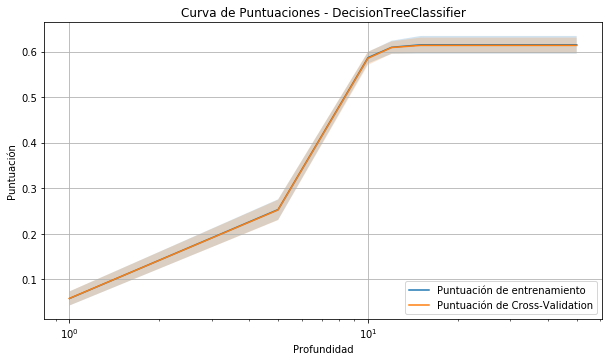

In [8]:
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(211)

plt.title("Curva de Puntuaciones - DecisionTreeClassifier")
plt.xlabel("Profundidad")
plt.ylabel("Puntuación")
plt.grid(ls='-')

# para una mejor representación, utilizamos semilogx, de esta forma vemos los valores bajos de x más separados
plt.semilogx(param_range, train_scores_mean, label="Puntuación de entrenamiento")
plt.semilogx(param_range, test_scores_mean, label="Puntuación de Cross-Validation")

# representamos también las bandas de precisión de los conjuntos de entrenamiento y test
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)

plt.legend(loc="lower right")
plt.show()

In [9]:
#generamos el estimador, limitando la profundidad a 12 niveles
tree = DecisionTreeClassifier(max_depth=12, random_state=0)
tree.fit(X_train, y_train)

#Generamos las predicciones
y_pred = tree.predict(X_test)

##########Cálculo de exactitud##########
acc_score_norm = accuracy_score(y_test, y_pred)
acc_score = accuracy_score(y_test, y_pred, normalize=False)
#scores = cross_val_score(tree, X_test, y_test)
#print('Precisión de la predicción Decision Tree Classifier: {}%'.format(round(np.mean(scores)*100,2)))
print('Precisión de la predicción Decision Tree Classifier: {}%'.format(round(tree.score(X_test,y_test)*100,2)))
print('Predicciones erróneas:',len(y_test)-acc_score,'/',len(y_test))

Precisión de la predicción Decision Tree Classifier: 76.51%
Predicciones erróneas: 1432 / 6096


In [10]:
# definimos el clasificador RandomForestClassifier sin valor para el parámetro que queremos evaluar con diferentes valores
clf = RandomForestClassifier(n_jobs=1, random_state=0, oob_score=True)

#param_range = [1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,70,90,100,150,200,300,500]

param_range = [1,5,10,15,20,25,30,40,50]

#obtenemos las puntuaciones de entrenamiento y test, utilizamos validación cruzada (cv=3)
train_scores, test_scores = validation_curve(clf, X_train, y_train,
                                             #param_name="n_estimators",
                                             param_name = "max_depth",
                                             param_range=param_range,
                                             cv=3, scoring="accuracy", n_jobs=1)

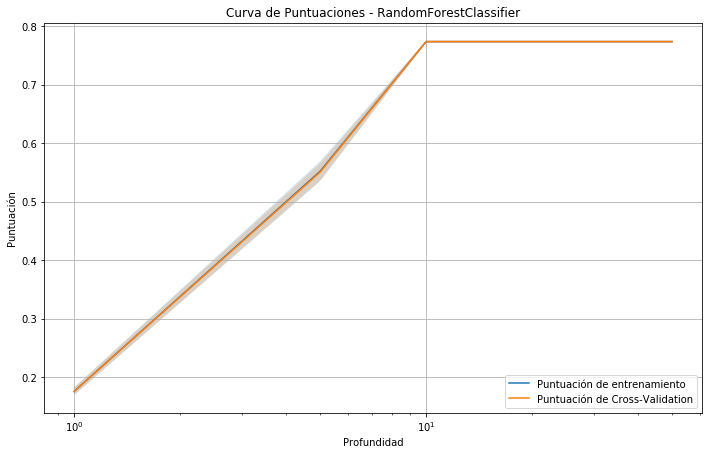

In [11]:
# calculamos la media y desviación típica de las puntuaciones del conjunto de entrenamiento
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

# calculamos la media y desviación típica de las puntuaciones del conjunto de test
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(10,12))
ax1 = fig.add_subplot(211)

plt.title("Curva de Puntuaciones - RandomForestClassifier")
#plt.xlabel("Número de Estimadores")
plt.xlabel("Profundidad")
plt.ylabel("Puntuación")
plt.grid(ls='-')

# para una mejor representación, utilizamos semilogx, de esta forma vemos los valores bajos de x más separados
plt.semilogx(param_range, train_scores_mean, label="Puntuación de entrenamiento")
plt.semilogx(param_range, test_scores_mean, label="Puntuación de Cross-Validation")


# representamos también las bandas de precisión de los conjuntos de entrenamiento y test
plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)

plt.tight_layout()
plt.legend(loc="lower right")
plt.show()

In [12]:
# creamos el clasificador RandomForestClassifier
clf = RandomForestClassifier(n_jobs=1, random_state=0, max_depth=10)

# entrenamos el modelo
clf.fit(X_train, y_train)

#Generamos las predicciones
y_pred = clf.predict(X_test)

##########Cálculo de exactitud##########
acc_score_norm = accuracy_score(y_test, y_pred)
acc_score = accuracy_score(y_test, y_pred, normalize=False)
#scores = cross_val_score(clf, X_test, y_test)
#print('Precisión de la predicción Random Forest Classifier: {}%'.format(round(np.mean(scores)*100,2)))
print('Precisión de la predicción Random Forest Classifier: {}%'.format(round(clf.score(X_test,y_test)*100,2)))
print('Predicciones erróneas:',len(y_test)-acc_score,'/',len(y_test))

Precisión de la predicción Random Forest Classifier: 76.77%
Predicciones erróneas: 1416 / 6096


In [13]:
gb_clf = GradientBoostingClassifier(random_state=2, max_depth=100)

gb_clf.fit(X_train, y_train)

# Obtenemos un array con las predicciones
y_pred = gb_clf.predict(X_test)

##########Cálculo de exactitud##########
acc_score_norm = accuracy_score(y_test, y_pred)
acc_score = accuracy_score(y_test, y_pred, normalize=False)
scores = cross_val_score(gb_clf, X_test, y_test)
print('Precisión de la predicción Gradient Boosting Classifier: {}%'.format(round(gb_clf.score(X_test,y_test)*100,2)))
print('Predicciones erróneas:',len(y_test)-acc_score,'/',len(y_test))

Precisión de la predicción Gradient Boosting Classifier: 76.51%
Predicciones erróneas: 1432 / 6096
